## AWS Fargate Network Bandwidth Benchmark

This notebook presents results of AWS Fargate network performance benchmark.

## Methodology

Benchmarks were performed as follows:

1. Create a Fargate task that runs an instance of iperf3 server.
2. Create an EC2 instance (c6in.xlarge) that runs an instance of iperf3 client.
3. Execute iperf3 client on the EC2 instance against the iperf3 server running in Fargate with following options:
   * `--parallel 4` - Use four connections / threads.
   * `--duration 1800` - Continue benchmark for 30 minutes.
   * `--reverse` - Make the server send data to the client, not the other way around.
4. Save report to Amazon S3 as JSON, and delete EC2 and Fargate resources.

The usage of `--reverse` flag means that the benchmark measures performance of traffic going out from Fargate (NetworkOut). The `--reverse` flag was used as it was lighter on the CPU inside Fargate. Without it the smallest tasks were limited by available CPU.

The benchmark was performed with a select combination of Fargate task sizes (CPU / Memory):
* 0.25 vCPU and 512 / 1024 / 2048 MB of memory
* 0.5 vCPU and 1024 / 2048 / 4096 MB of memory
* 1 vCPU and 2048 / 4096 / 8192 MB of memory
* 2 vCPU and 4069 / 8192 / 16384 MB of memory
* 4 vCPU and 8192 / 16384 / 30720 MB of memory

The results shown is this notebook were obtained on 2024-06-15 from eu-west-1 and eu-north-1 regions.


## Preparation

In [25]:
import gzip
import json
import os
import os.path

import pandas as pd
import matplotlib.pyplot as plt

In [66]:
def load_data(path_filter):
    """Load reports that match given path filter"""
    report_files = sorted([os.path.join(root, file) for root, dirs, files in os.walk('data/') for file in files])
    rows = []
    for file in report_files:
        if path_filter not in file:
            # Skip file since its path did not match the filter
            continue

        # Gunzip & json decode report
        with gzip.open(file) as fp:
            report = json.load(fp)

        cpu, memory = report['server']['cpu'], report['server']['memory']
        for interval in report['intervals']:
            rows.append({
                'region': report['aws_region'],
                'cpu': int(cpu),
                'memory': int(memory),
                'time': interval['sum']['start'],
                'time_minutes': interval['sum']['start'] / 60,
                'rate': interval['sum']['bits_per_second'],
                'rate_gb': interval['sum']['bits_per_second'] / 1000 / 1000 / 1000,
                'bytes': interval['sum']['bytes'],
                'bytes_gb': interval['sum']['bytes'] / 1024 / 1024 / 1024
            })
    print('Got %s datapoints with filter %s' % (len(rows), path_filter))

    return pd.DataFrame(rows)

def graph_throughput(df):
    """Draw graphs of throughput over time."""
    for key, grp in df.groupby('cpu'):
        fig, ax = plt.subplots(figsize=(12, 4))
        for key1, grp1 in grp.groupby('memory'):
            label = '%s vCPU & %s MB' % (key / 1024, key1)
            plot = grp1.plot(ax=ax, kind='line', x='time_minutes', y='rate_gb', label=label, ylim=(0.0, 15.0))
            plt.ylabel('Throughput (Gbps)')
            plt.xlabel('Time (minutes)')
        ax.set_title('%s vCPU' % (key / 1024))

def graph_bytes(df):
    """Draw graphs of cumulative downloaded bytes over time."""
    for key, grp in df.groupby('cpu'):
        fig, ax = plt.subplots(figsize=(12, 4))
        for key1, grp1 in grp.groupby('memory'):
            label = '%s vCPU & %s MB' % (int(key) / 1024, key1)
            grp1 = grp1.set_index('time')
            grp1['bytes_cum'] = grp1['bytes'].cumsum()
            plot = grp1.plot(ax=ax, kind='line', x='time_minutes', y='bytes_cum', label=label, ylim=(0.0, 10.0*10**11))
            plt.ylabel('Bytes')
            plt.xlabel('Time (minutes)')
        ax.set_title('%s vCPU' % (int(key) / 1024))

def compute_summary_table(df):
    """Compute summary for bandwidth of different cpu / memory combos"""
    summary_data = []
    for (cpu, memory), grp in df.groupby(['cpu', 'memory']):
        quantiles = grp['rate_gb'].quantile([0.1, 0.95])
        grp = grp.set_index('time')
        grp['rate_diff'] = grp['rate_gb'].diff().fillna(0).round(2)
        rate_drop_time = grp[grp['rate_gb'] >= quantiles[0.95]].index.max()

        summary_data.append({
            'vCPU': cpu / 1024,
            'Memory (MB)': memory,
            'Baseline (Gbps)': round(quantiles[0.1], 3),
            'Burst (Gbps)': round(quantiles[0.95], 3),
            'Burst Duration (seconds)': '-' if rate_drop_time > 1700 else round(rate_drop_time)
        })

    return pd.DataFrame(summary_data)

import numpy as np
import matplotlib.colors as mcolors

def label_bars(bars, values, ax):
    """
    Attach a text label above each bar displaying values.

    Modified from https://matplotlib.org/examples/api/barchart_demo.html
    """
    for bar, value in zip(bars, values):
        x = bar.get_x() + bar.get_width() / 2.
        y = 1.05 * bar.get_height()
        ax.text(x, y, value, ha='center', va='bottom', rotation=45)

def graph_throughput_summary(dfs, col, ymax):
    """Create a grouped bar plot of throughput summary."""

    # Variables
    N = len(dfs) # number of groups
    width = 0.28 # width of a bar
    gap = 0.03 # gap between bars in a group
    ind = np.arange(N) # indices for groups

    # Colors for N groups
    color = list(mcolors.TABLEAU_COLORS.keys())[:N]

    # Create new figure
    fig, ax = plt.subplots(figsize=(12,4))

    # Iterate over 3 unique memory values of each vCPU combo
    for i in range(3):
        # Create bars for the values if item i in each group
        values = [df[col][i] for df in dfs]
        bars = ax.bar(ind + i * (width + gap), values, width, color=color)

        # Label each bar with task memory
        memories = ['%s MB' % df['Memory (MB)'][i] for df in dfs]
        label_bars(bars, memories, ax)


    # Titles & Labels
    ax.set_ylabel('Throughput (Gbps)')
    ax.set_title('%s Throughput' % (col.split(' ', 1)[0]))
    ax.set_xticks(ind + width + gap)
    ax.set_ylim(0, ymax)
    ax.set_xticklabels(('0.25 vCPU', '0.5 vCPU', '1 vCPU', '2 vCPU', '4 vCPU'))

def graph_summary(df):
    dfs = [
        df[df['vCPU'] == 0.25].reset_index(),
        df[df['vCPU'] == 0.50].reset_index(),
        df[df['vCPU'] == 1.00].reset_index(),
        df[df['vCPU'] == 2.00].reset_index(),
        df[df['vCPU'] == 4.00].reset_index(),
    ]

    graph_throughput_summary(dfs, 'Baseline (Gbps)', 2)
    graph_throughput_summary(dfs, 'Burst (Gbps)', 15)

In [45]:
!aws --profile sandbox-admin s3 --quiet sync s3://en1-network-benchmark-infra-reports/reports/ data/eu-north-1/
!aws --profile sandbox-admin s3 --quiet sync s3://ew1-network-benchmark-infra-reports/reports/ data/eu-west-1/

In [67]:
df_ew1 = load_data('eu-west-1/date=2024-06-15/fargate')
df_en1 = load_data('eu-north-1/date=2024-06-15/fargate')

Got 2700 datapoints with filter eu-west-1/date=2024-06-15/fargate
Got 2700 datapoints with filter eu-north-1/date=2024-06-15/fargate


In [68]:
# eu-north-1
df_en1.head()

,region,cpu,memory,time,time_minutes,rate,rate_gb,bytes,bytes_gb
0,eu-north-1,1024,2048,0.000000,0.000000,4.621978e+09,4.621978,5781323776,5.384277
1,eu-north-1,1024,2048,10.006666,0.166778,4.605556e+09,4.605556,5756944384,5.361572
2,eu-north-1,1024,2048,20.006664,0.333444,4.636592e+09,4.636592,5795741696,5.397705
3,eu-north-1,1024,2048,30.006666,0.500111,4.640579e+09,4.640579,5800722432,5.402344
4,eu-north-1,1024,2048,40.006663,0.666778,4.612791e+09,4.612791,5765988352,5.369995


In [69]:
# eu-west-1
df_ew1.head()

,region,cpu,memory,time,time_minutes,rate,rate_gb,bytes,bytes_gb
0,eu-west-1,1024,2048,0.000000,0.000000,4.527876e+09,4.527876,5664014336,5.275024
1,eu-west-1,1024,2048,10.007367,0.166789,4.545805e+09,4.545805,5682233344,5.291992
2,eu-west-1,1024,2048,20.007326,0.333455,4.558995e+09,4.558995,5698748416,5.307373
3,eu-west-1,1024,2048,30.007334,0.500122,4.536236e+09,4.536236,5670305792,5.280884
4,eu-west-1,1024,2048,40.007352,0.666789,4.505940e+09,4.505940,5632425984,5.245605


## Results - eu-west-1

Summary of network performance on different kinds of Fargate tasks in eu-west-1 region.

In [70]:
ew1_summary = compute_summary_table(df_ew1)
ew1_summary

,vCPU,Memory (MB),Baseline (Gbps),Burst (Gbps),Burst Duration (seconds)
0,0.25,512,0.063,4.214,410
1,0.25,1024,0.127,4.525,560
2,0.25,2048,0.254,4.688,710
3,0.50,1024,0.127,4.571,630
4,0.50,2048,0.254,4.705,780
5,0.50,4096,0.508,4.888,1000
6,1.00,2048,0.254,4.577,730
7,1.00,4096,0.508,4.895,1120
8,1.00,8192,0.744,9.719,300
9,2.00,4096,0.744,9.720,340


Graphs of baseline and burst capacity for different task sizes.

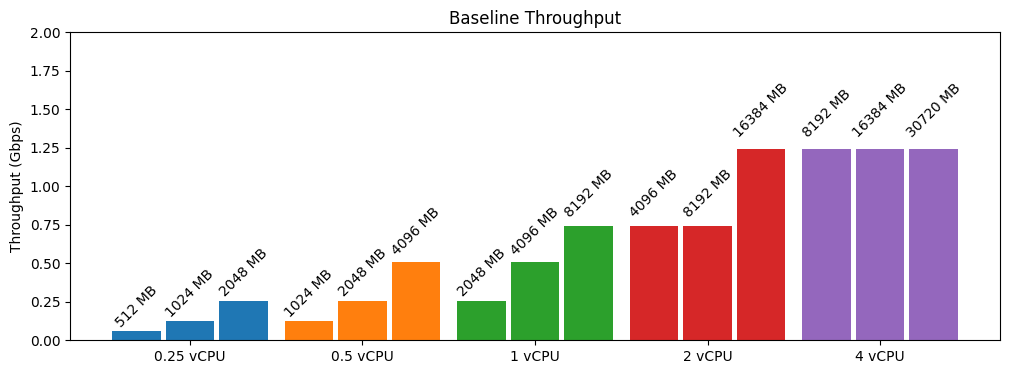

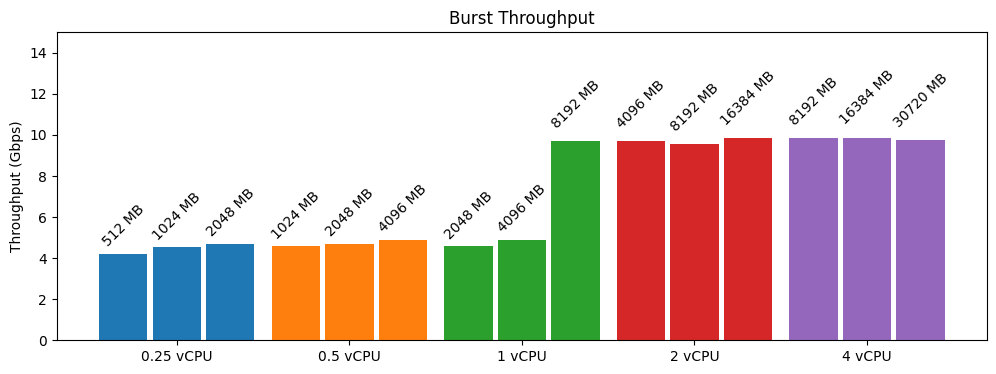

In [71]:
graph_summary(ew1_summary)

Graphs of network throughput over time (minutes since benchmark began).

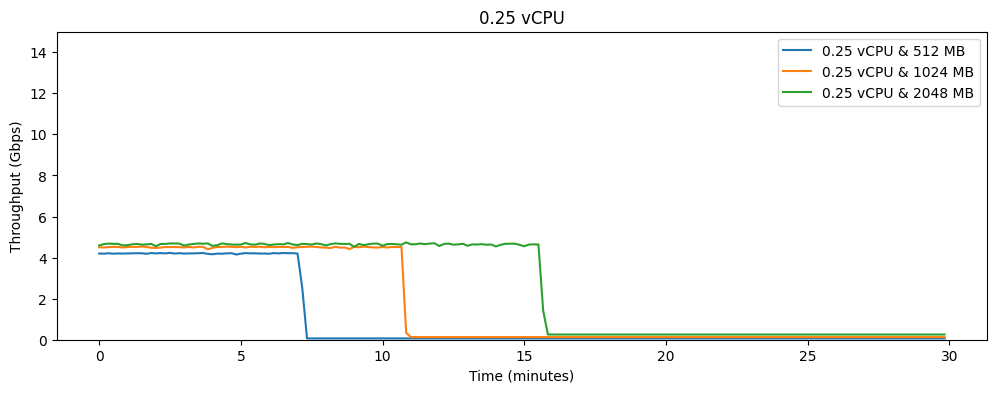

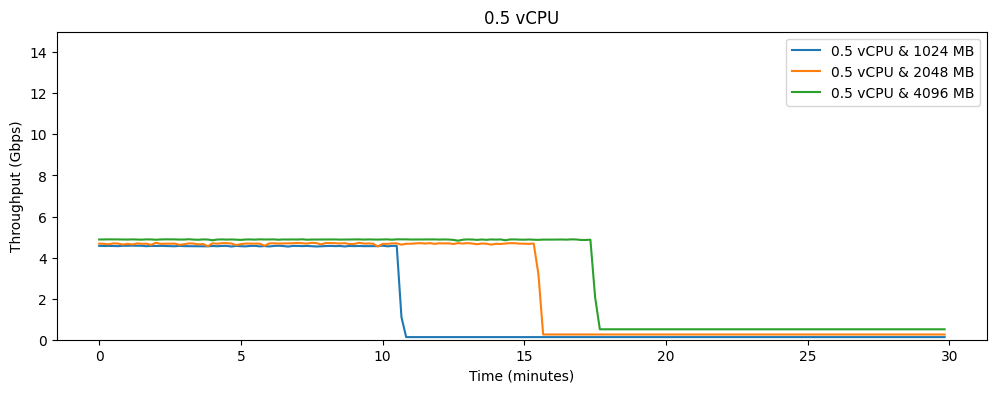

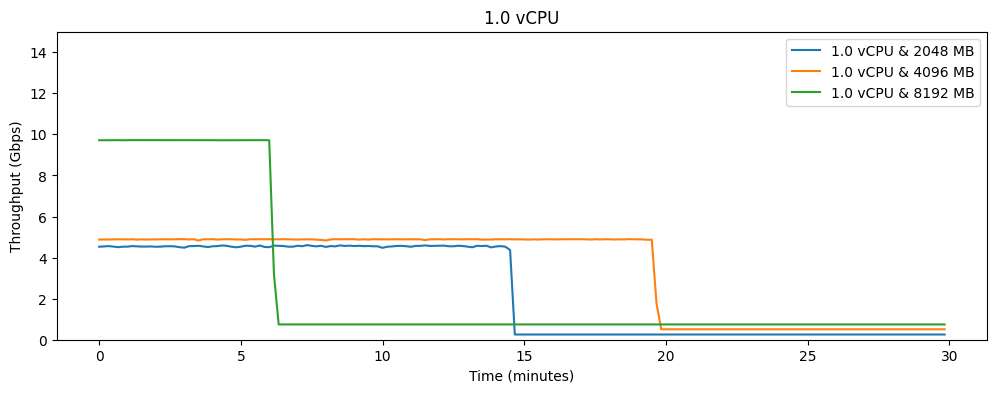

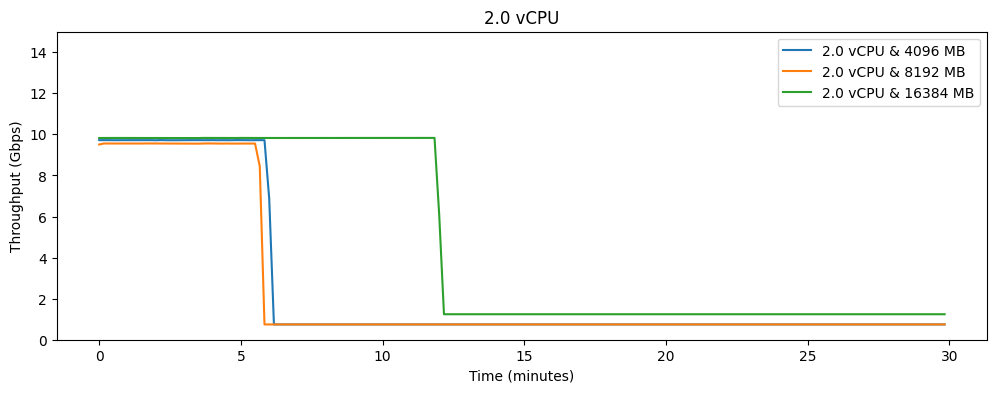

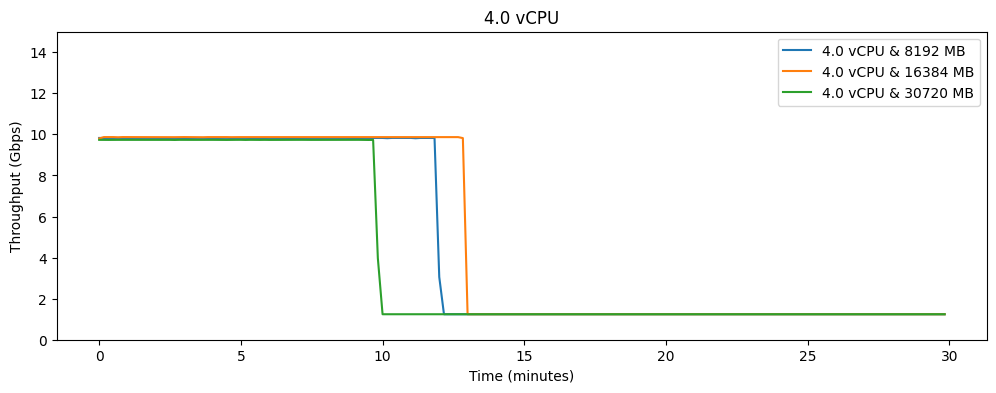

In [72]:
graph_throughput(df_ew1)

### Observations

* All tasks have very stable baseline performance.
  * Bigger tasks seem to have slightly faster network.
* Some tasks are able to burst up-to 10 Gbps.
  * Most tasks are not able to burst beyond baseline capacity.


## Results - eu-north-1

Summary of network performance on different kinds of Fargate tasks in eu-north-1 region.

In [73]:
en1_summary = compute_summary_table(df_en1)
en1_summary

,vCPU,Memory (MB),Baseline (Gbps),Burst (Gbps),Burst Duration (seconds)
0,0.25,512,0.063,4.185,410
1,0.25,1024,0.127,4.547,570
2,0.25,2048,0.254,4.683,920
3,0.50,1024,0.127,4.584,540
4,0.50,2048,0.254,4.738,820
5,0.50,4096,0.508,4.819,900
6,1.00,2048,0.254,4.706,920
7,1.00,4096,0.508,4.782,1080
8,1.00,8192,0.744,9.720,310
9,2.00,4096,0.775,11.802,260


Graphs of baseline and burst capacity for different task sizes.

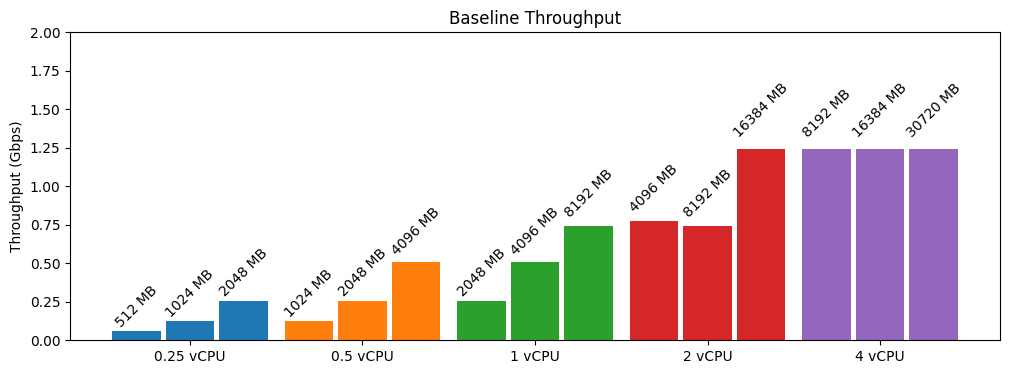

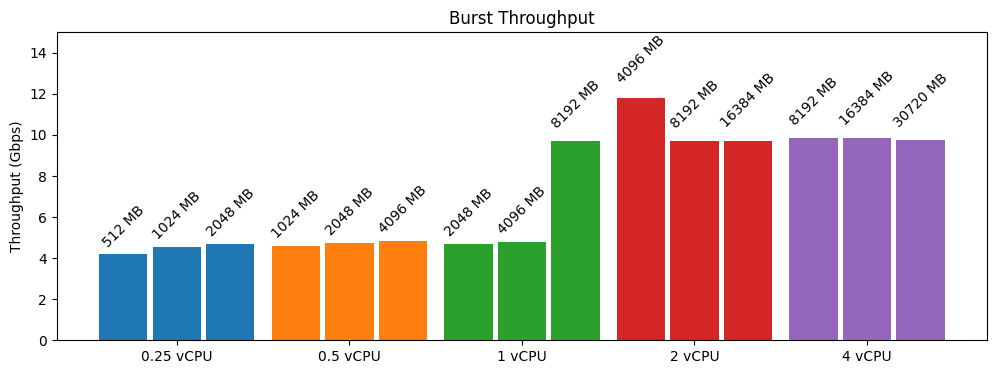

In [74]:
graph_summary(en1_summary)

Graphs of network throughput over time (minutes since benchmark began).

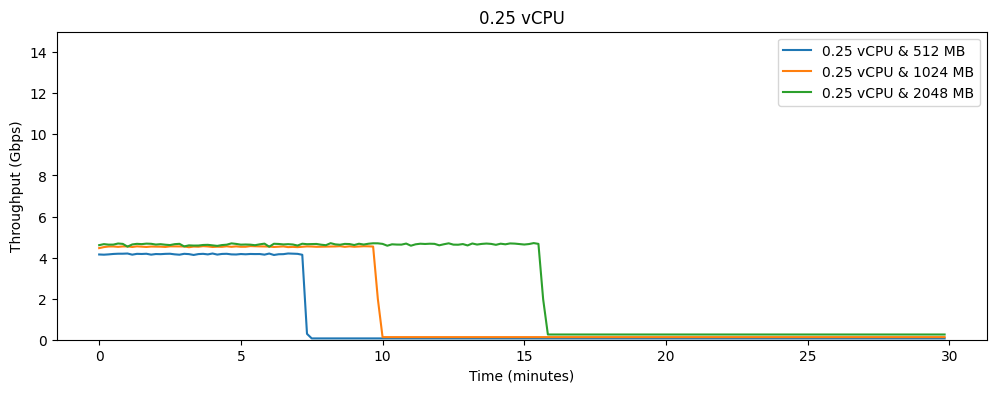

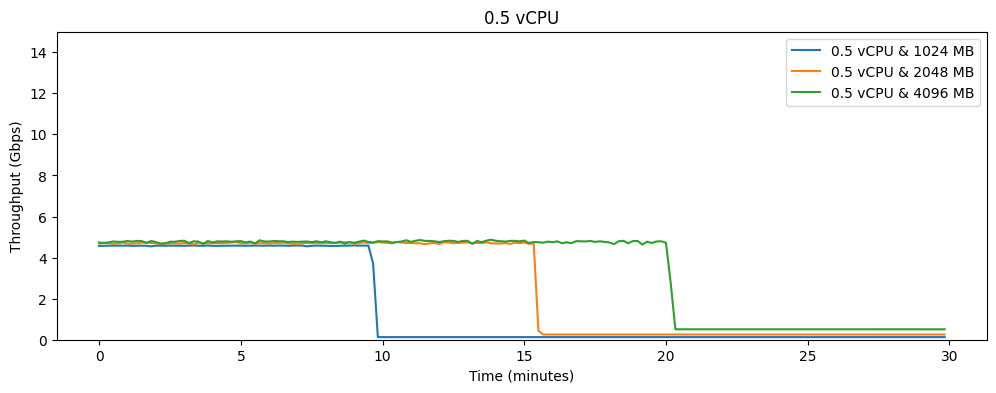

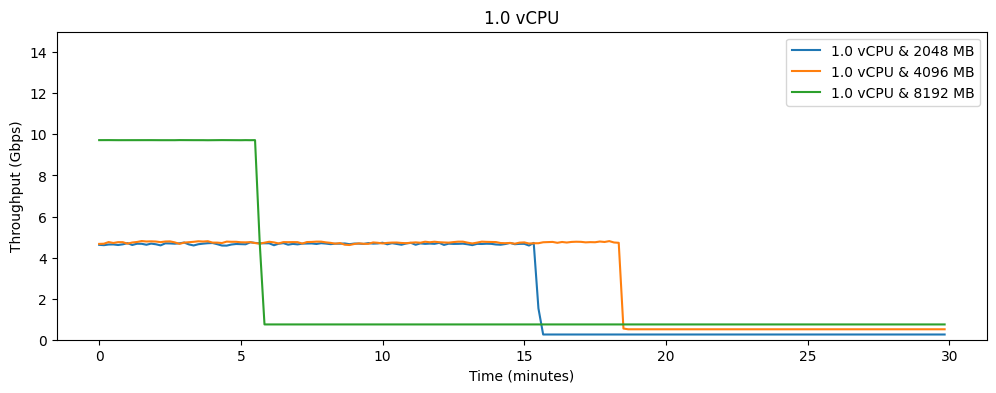

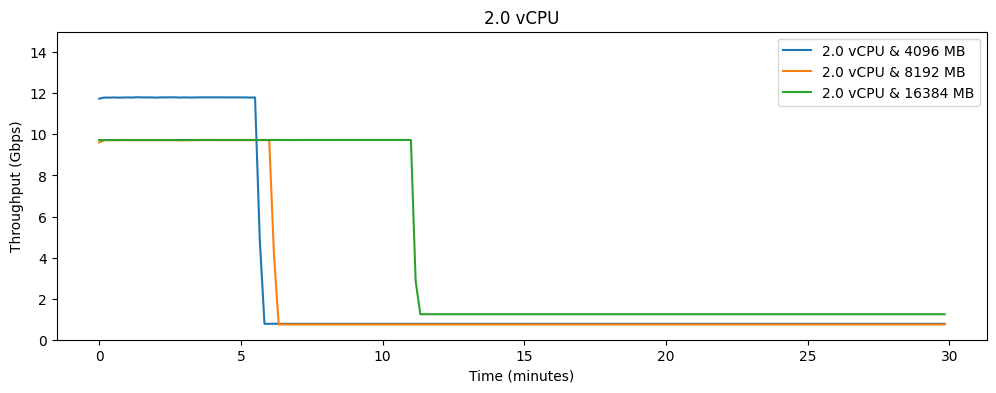

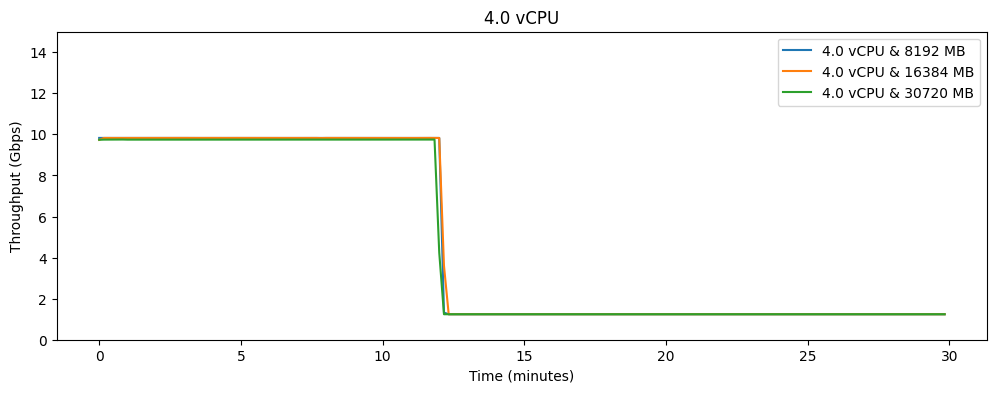

In [75]:
graph_throughput(df_en1)

### Observations

We can make the following observations from above results:

* Baseline performance seems to change based on allocated memory
  * With 1024 MB you get ~125 Mbps
  * With 2048 MB you get ~250 Mbps
  * With 4096 MB you get ~500 Mbps (1 vCPU or less) or ~750 Mbps (2 vCPUs)
  * With 8192 MB you get ~750 Mbps (2 vCPU or less) or ~1250 Mbps (4 vCPUs)
  * With 16 GB or 32 GB you get ~1250 Mbps
* Burst performance is either around 5 Gbps (smaller tasks) or 10 Gbps (larger tasks)
* Burst duration is longer for larger tasks